In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import silhouette_score


dataset_name = "the-reddit-climate-change-dataset"
posts_sample_path = dataset_name + "-posts-sample.csv"
posts_path = dataset_name + "-posts.csv"
comments_path_sample = dataset_name + "-comments-sample.csv"
comments_path = dataset_name + "-comments.csv"

In [3]:
posts = pd.read_csv(posts_path)
comments = pd.read_csv(comments_path)
print(f"Posts: {posts.shape[0]}, Comments: {comments.shape[0]}")

Posts: 620908, Comments: 4600698


In [4]:
posts.isna().sum()

type                   0
id                     0
subreddit.id           0
subreddit.name         0
subreddit.nsfw         0
created_utc            0
permalink              0
domain                 0
url               167148
selftext          453760
title                  0
score                  0
dtype: int64

In [22]:
comments.columns

Index(['type', 'id', 'subreddit.id', 'subreddit.name', 'subreddit.nsfw',
       'created_utc', 'permalink', 'body', 'sentiment', 'score'],
      dtype='object')

In [23]:
comments.describe()

,created_utc,sentiment,score
count,4.600698e+06,4.543567e+06,4.600698e+06
mean,1.560607e+09,-5.827452e-03,9.552084e+00
std,7.576261e+07,6.581439e-01,1.157160e+02
min,1.262306e+09,-1.000000e+00,-2.379000e+03
25%,1.518140e+09,-6.369000e-01,1.000000e+00
50%,1.571668e+09,0.000000e+00,2.000000e+00
75%,1.622571e+09,6.249000e-01,5.000000e+00
max,1.661990e+09,1.000000e+00,3.638500e+04


## Comments Sentiment Analysis

### Distribution of Sentiment

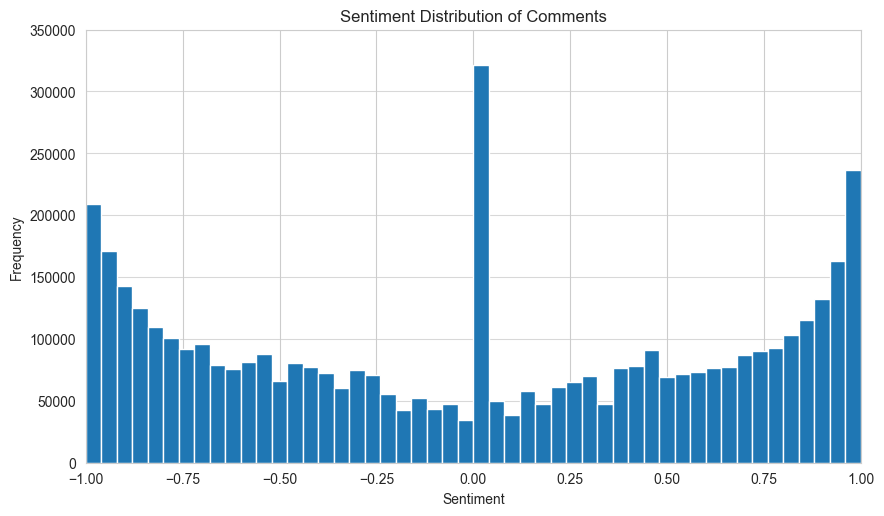

In [123]:
# Plot histogram
plt.figure(figsize=(10, 5.625))
# comments_nonzero = comments[comments['sentiment'] != 0]
plt.hist(comments['sentiment'], bins=50)
plt.xlim(-1, 1)
plt.ylim(0, 350_000)
plt.title('Sentiment Distribution of Comments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show plot
plt.savefig('figures/sentiment-distribution.png', dpi=300)
plt.show()


### Word Cloud for Comments

In [47]:
# Prepare data segments
from wordcloud import WordCloud, STOPWORDS

negative_comments = comments[comments['sentiment'] <= -0.5]
neutral_comments = comments[(comments['sentiment'] > -0.5) & (comments['sentiment'] < 0.5)]
positive_comments = comments[comments['sentiment'] >= 0.5]

def sample_data(df, frac=0.01):
    return df.sample(frac=0.01, random_state=42)

# negative_comments_sampled = negative_comments.sample(frac=0.01, random_state=42)
# neutral_comments_sampled = neutral_comments.sample(frac=0.01, random_state=42)
# positive_comments_sampled = positive_comments.sample(frac=0.01, random_state=42)

print("Negative Comments: ", negative_comments.shape[0])
print("Neutral Comments: ", neutral_comments.shape[0])
print("Positive Comments: ", positive_comments.shape[0])

Negative Comments:  1402334
Neutral Comments:  1787703
Positive Comments:  1353530


In [44]:
my_stopwords = STOPWORDS.union({'climate', 'change','gt', 'people', 'will'})
def generate_word_cloud(df, title):
    # sample the data
    # df = df.sample(frac=0.01, random_state=42)
    print(f"Sampled {df.shape[0]} comments")
    text = df['body'].str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=my_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

Sampled 14023 comments


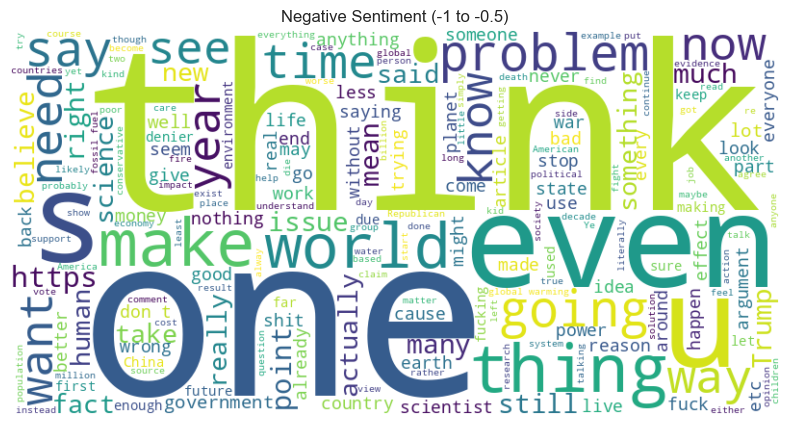

In [42]:
# Generate word clouds for each sentiment category
generate_word_cloud(negative_comments_sampled, 'Negative Sentiment (-1 to -0.5)')

Sampled 13535 comments


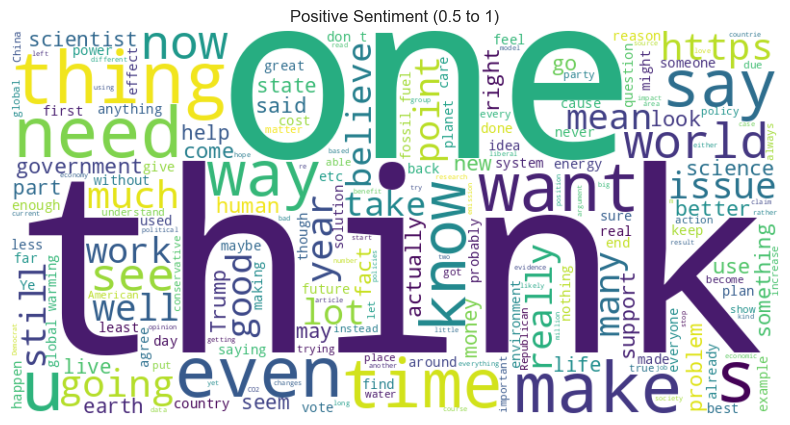

In [43]:
generate_word_cloud(positive_comments_sampled, 'Positive Sentiment (0.5 to 1)')

### Finding the Difference

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

negative_comments_sampled = sample_data(negative_comments)
positive_comments_sampled = sample_data(positive_comments)

vectorizer = TfidfVectorizer(stop_words='english')
all_texts = negative_comments_sampled['body'].tolist() + positive_comments_sampled['body'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

feature_names = vectorizer.get_feature_names_out()

# separate the tfidf matrix into two groups and get score
tfidf_neg = tfidf_matrix[:negative_comments_sampled.shape[0]].toarray().mean(axis=0)
tfidf_pos = tfidf_matrix[negative_comments_sampled.shape[0]:].toarray().mean(axis=0)

# Create dataframes for each group
df_scores_neg = pd.DataFrame(tfidf_neg, index=feature_names, columns=["tfidf"])
df_scores_pos = pd.DataFrame(tfidf_pos, index=feature_names, columns=["tfidf"])

# Calculate the difference in TF-IDF scores between groups
df_scores_diff = df_scores_neg - df_scores_pos
significant_words = df_scores_diff.sort_values(by="tfidf", ascending=False)
print(significant_words.head(20))

             tfidf
war       0.007363
fuck      0.007110
bad       0.006667
shit      0.006303
people    0.006115
worse     0.005848
die       0.005396
problem   0.005151
kill      0.004649
fucking   0.004412
stupid    0.004390
wrong     0.004334
fucked    0.004229
bullshit  0.004159
change    0.004144
threat    0.004001
climate   0.003881
stop      0.003851
crisis    0.003720
death     0.003679


Words more significant in neg:

```
             tfidf
war       0.007363
fuck      0.007110
bad       0.006667
shit      0.006303
people    0.006115
worse     0.005848
die       0.005396
problem   0.005151
kill      0.004649
fucking   0.004412
stupid    0.004390
wrong     0.004334
fucked    0.004229
bullshit  0.004159
change    0.004144
threat    0.004001
climate   0.003881
stop      0.003851
crisis    0.003720
death     0.003679
```

more significant in pos:

```
              tfidf
like      -0.009065
energy    -0.008129
good      -0.007259
better    -0.006525
best      -0.006295
party     -0.005864
great     -0.005802
pretty    -0.005320
support   -0.004262
help      -0.004199
free      -0.003864
https     -0.003818
warming   -0.003687
bernie    -0.003620
yes       -0.003579
love      -0.003546
carbon    -0.003483
important -0.003435
com       -0.003373
policy    -0.002984
```

## Clustering

Using DBSCAN

In [144]:
# plot
comments_sampled = comments.sample(frac=1, random_state=42)
# plt.figure(figsize=(10, 5.625))
# plt.scatter(comments_sampled['sentiment'], comments_sampled['score'], alpha=0.5)
# plt.xlabel('Sentiment')
# plt.ylabel('Score')
# plt.savefig('figures/sentiment-score-raw.png', dpi=300)
# plt.show()

In [204]:
comments_sampled['score'].value_counts()

score
 1      1402
 2       663
 3       406
 0       277
 4       189
        ... 
-33        1
-56        1
 648       1
 49        1
 80        1
Name: count, Length: 171, dtype: int64

<Axes: >

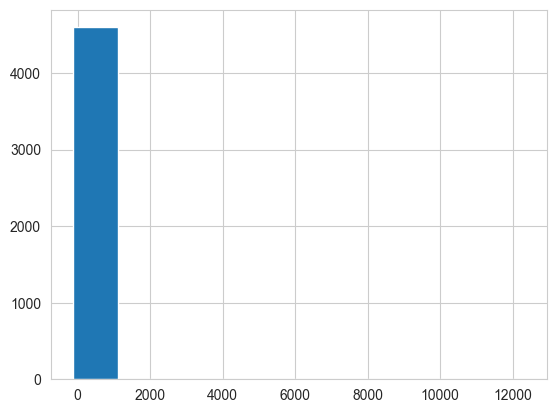

In [152]:
avg0to4 = comments_sampled[comments_sampled['score'].between(0, 4)]['score'].mean()
comments_sampled.loc[comments_sampled['score'].astype(np.float64).between(0, 4), 'score'] = avg0to4

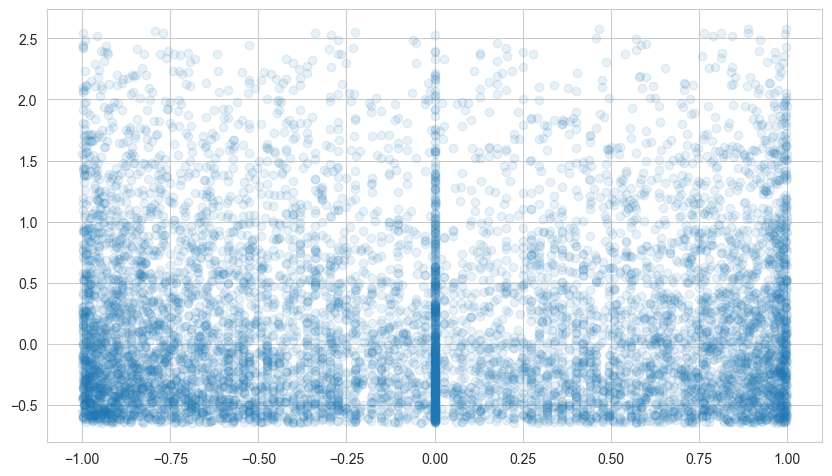

In [166]:
# preprocess then plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import zscore

# drop the lower ones
comments_sampled = comments_sampled[comments_sampled['score'] >= 500]

comments_sampled.dropna(subset=['sentiment'], inplace=True)
# comments_sampled['score_shifted'] = abs(comments_sampled['score'].min()) + comments_sampled['score'] 
# comments_sampled['score_log'] = np.log1p(comments_sampled['score_shifted'])
comments_sampled['score_log'] = np.log1p(comments_sampled['score'])
# scaler = StandardScaler()
scaler = RobustScaler()
comments_sampled['score_scaled'] = scaler.fit_transform(comments_sampled[['score_log']]).flatten()
comments_sampled['z_score'] = zscore(comments_sampled['score_log'])
comments_filtered = comments_sampled[(comments_sampled['z_score'] > -3) & (comments_sampled['z_score'] < 3)]
plt.figure(figsize=(10, 5.625))
plt.scatter(comments_filtered['sentiment'], comments_filtered['score_scaled'], alpha=0.1)
# plt.savefig('figures/score-sentiment.png', dpi=300)
plt.show()

In [167]:
comments_sampled.describe()

,created_utc,sentiment,score,score_shifted,score_log,score_scaled,z_score
count,8.549000e+03,8549.000000,8549.000000,8549.000000,8549.000000,8549.000000,8.549000e+03
mean,1.565896e+09,-0.047902,1572.082934,2072.082934,7.015581,0.234416,-1.305307e-15
std,6.578158e+07,0.670771,2105.701874,2105.701874,0.711767,0.782647,1.000058e+00
min,1.263479e+09,-0.999700,500.000000,1000.000000,6.216606,-0.644124,-1.122590e+00
25%,1.525056e+09,-0.690800,643.000000,1143.000000,6.467699,-0.368026,-7.697953e-01
50%,1.572784e+09,-0.033900,899.000000,1399.000000,6.802395,0.000000,-2.995350e-01
75%,1.619980e+09,0.599400,1598.000000,2098.000000,7.377134,0.631974,5.079945e-01
max,1.661988e+09,0.999900,36385.000000,36885.000000,10.501939,4.067959,4.898462e+00


<Axes: >

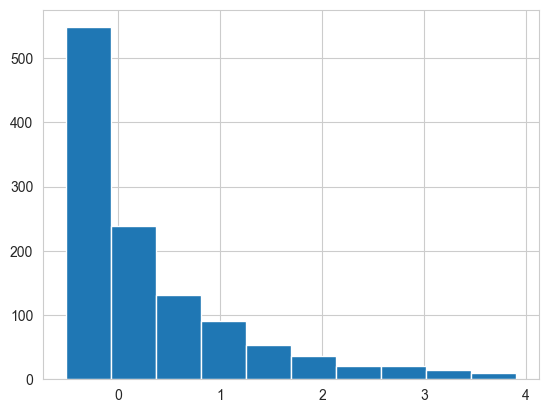

In [67]:
comments_filtered['score_scaled'].hist()

In [19]:
comments_sampled['score'].value_counts()

score
10      602
11      527
13      419
12      405
14      353
       ... 
3272      1
177       1
644       1
333       1
291       1
Name: count, Length: 363, dtype: int64

<Axes: xlabel='score_scaled'>

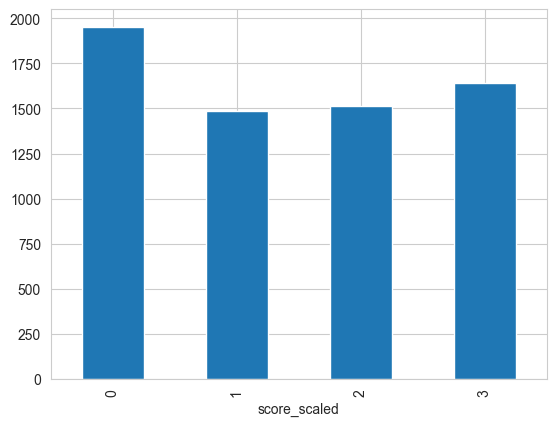

In [20]:
num_quantiles = 4
binned = pd.qcut(comments_filtered['score_scaled'], q=num_quantiles, labels=False)
binned.value_counts().sort_index().plot(kind='bar')

In [112]:
comments_sampled['subreddit.nsfw'].value_counts()

subreddit.nsfw
False    4578
True       23
Name: count, dtype: int64

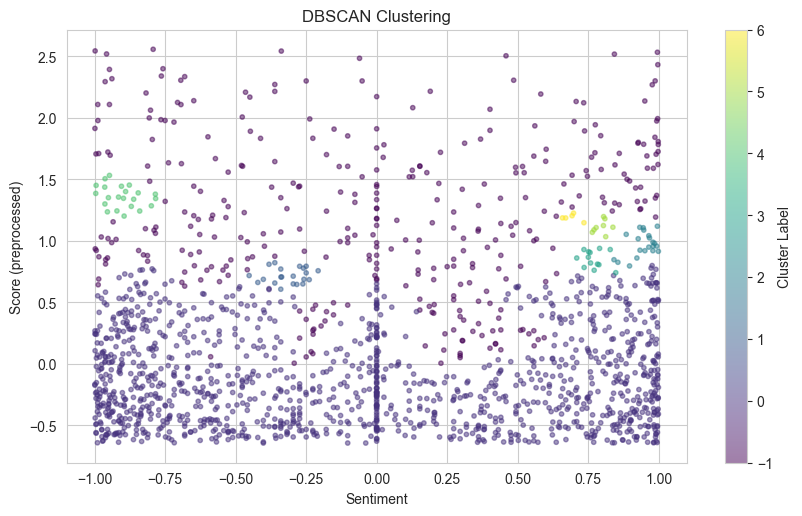

In [252]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=10)
X = comments_filtered[['sentiment', 'score_scaled']]
X = X.sample(frac=0.2, random_state=42)
X = X.dropna()
clusters = dbscan.fit_predict(X)

plt.figure(figsize=(10, 5.625))
plt.scatter(X['sentiment'], X['score_scaled'], c=clusters, cmap='viridis', s=10, alpha=0.5)
plt.title('DBSCAN Clustering')
plt.xlabel('Sentiment')
plt.ylabel('Score (preprocessed)')
plt.colorbar(label='Cluster Label')
# plt.savefig('dbscan.png', dpi=300)
plt.show()

In [253]:
labels_dbscan = clusters
if np.any(labels_dbscan == -1):
    silhouette_dbscan = silhouette_score(X[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1])
    print("Silhouette Score for DBSCAN (excluding noise):", silhouette_dbscan)
else:
    silhouette_dbscan = silhouette_score(X, labels_dbscan)
    print("Silhouette Score for DBSCAN:", silhouette_dbscan)

Silhouette Score for DBSCAN (excluding noise): 0.03609271263590209


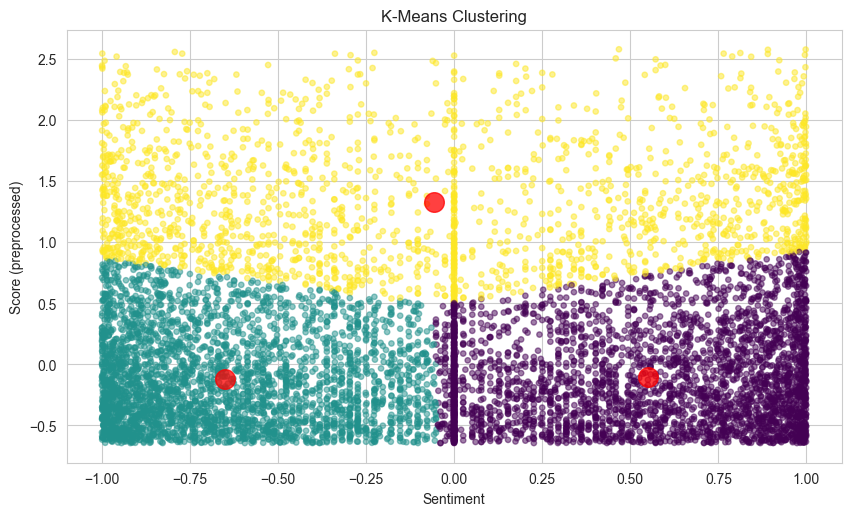

In [250]:
from sklearn.cluster import KMeans
kmeans = KMeans(3, random_state=42)
kmeans.fit(X)
clusters = kmeans.predict(X)
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 5.625))
plt.scatter(X['sentiment'], X['score_scaled'], c=clusters, cmap='viridis', s=15, alpha=.5)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title('K-Means Clustering')
plt.xlabel('Sentiment')
plt.ylabel('Score (preprocessed)')
# plt.savefig('figures/k-means.png', dpi=300)
plt.show()

labels_kmeans = clusters

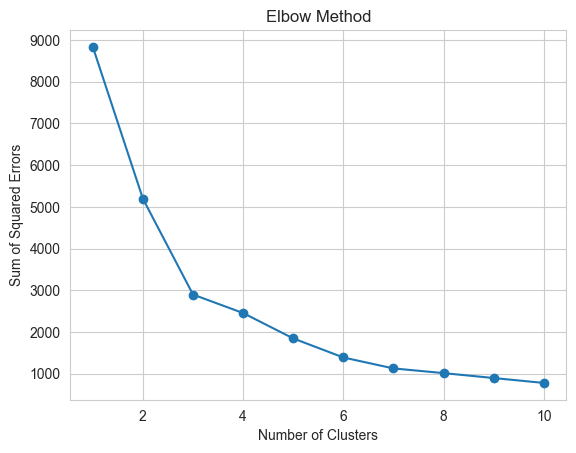

In [170]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.show()

In [91]:
# comments_sampled = comments_sampled[comments_sampled['score'] >= 10]
comments_sampled.describe()

,created_utc,sentiment,score,score_shifted,score_log,score_scaled,z_score
count,8.549000e+03,8549.000000,8549.000000,8549.000000,8549.000000,8549.000000,8.549000e+03
mean,1.565896e+09,-0.047902,1572.082934,2072.082934,7.433266,0.311467,6.474591e-16
std,6.578158e+07,0.670771,2105.701874,2105.701874,0.540356,0.890310,1.000058e+00
min,1.263479e+09,-0.999700,500.000000,1000.000000,6.908755,-0.552737,-9.707342e-01
25%,1.525056e+09,-0.690800,643.000000,1143.000000,7.042286,-0.332726,-7.236023e-01
50%,1.572784e+09,-0.033900,899.000000,1399.000000,7.244228,0.000000,-3.498613e-01
75%,1.619980e+09,0.599400,1598.000000,2098.000000,7.649216,0.667274,3.996677e-01
max,1.661988e+09,0.999900,36385.000000,36885.000000,10.515587,5.390010,5.704575e+00


{'bodies': [<matplotlib.collections.PolyCollection at 0x316cf05c0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x4a2ed4560>,
 'cmins': <matplotlib.collections.LineCollection at 0x3180d4110>,
 'cbars': <matplotlib.collections.LineCollection at 0x4a2ff4590>}

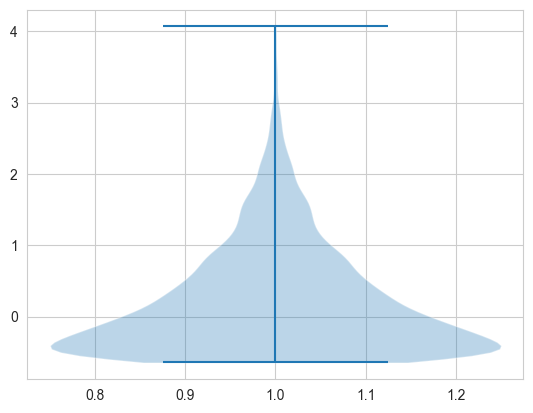

In [171]:
plt.violinplot(comments_sampled['score_scaled'])

<Axes: >

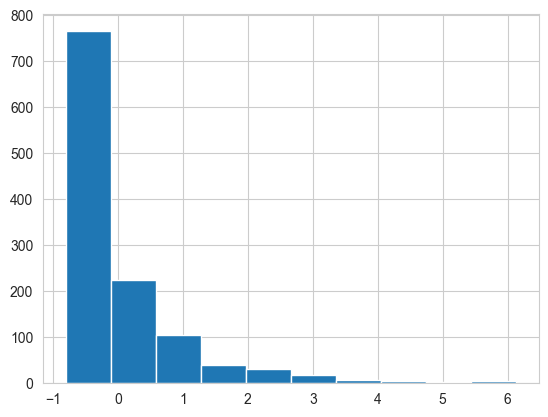

In [33]:
comments_sampled['score_scaled'].hist()

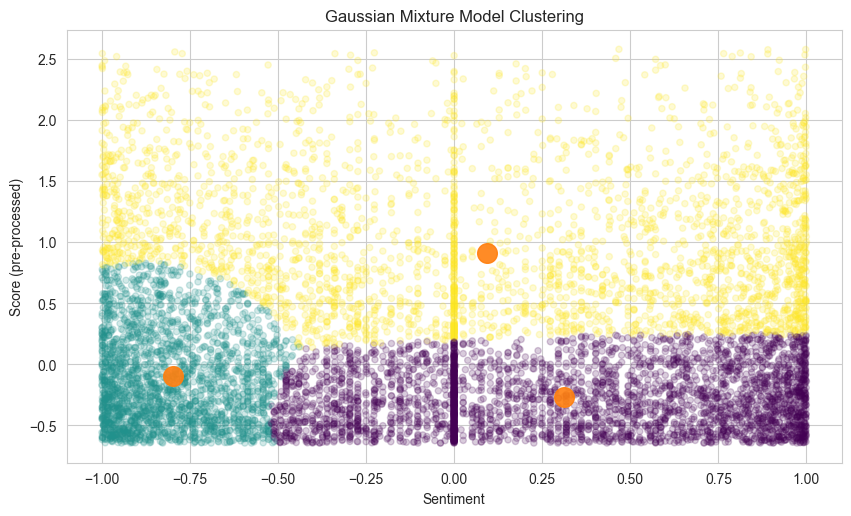

In [249]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)
clusters = gmm.predict(X)

plt.figure(figsize=(10, 5.625))
plt.scatter(X['sentiment'], X['score_scaled'], c=clusters, cmap='viridis', s=20, alpha=0.2)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Sentiment')
plt.ylabel('Score (pre-processed)')

# Plot centers
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='C1', s=200, alpha=0.9)  # cluster centers
# plt.savefig('figures/gmm.png', dpi=300)
plt.show()

labels_gmm = clusters

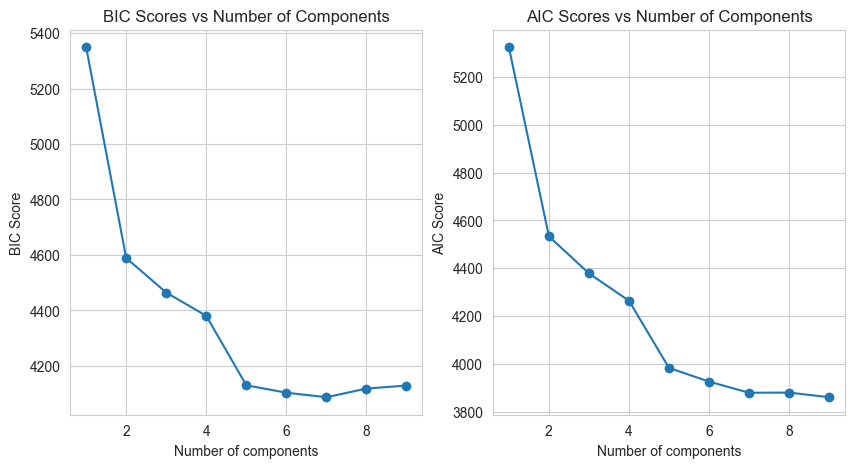

In [53]:
bic = []
aic = []
n_components_range = range(1, 10)  # Adjust according to your guess about possible clusters

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic.append(gmm.bic(X))  # BIC for the model
    aic.append(gmm.aic(X))  # AIC for the model

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic, marker='o')
plt.title('BIC Scores vs Number of Components')
plt.xlabel('Number of components')
plt.ylabel('BIC Score')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic, marker='o')
plt.title('AIC Scores vs Number of Components')
plt.xlabel('Number of components')
plt.ylabel('AIC Score')

plt.show()

In [248]:
# Calculate silhouette score for K-means
silhouette_kmeans = silhouette_score(X, labels_kmeans)
print("Silhouette Score for K-means:", silhouette_kmeans)

# Calculate silhouette score for GMM
silhouette_gmm = silhouette_score(X, labels_gmm)
print("Silhouette Score for GMM:", silhouette_gmm)

Silhouette Score for K-means: 0.3934638017415395
Silhouette Score for GMM: 0.23922790927849363


In [251]:
# with 3 clusters
# Calculate silhouette score for K-means
silhouette_kmeans = silhouette_score(X, labels_kmeans)
print("Silhouette Score for K-means:", silhouette_kmeans)

# Calculate silhouette score for GMM
silhouette_gmm = silhouette_score(X, labels_gmm)
print("Silhouette Score for GMM:", silhouette_gmm)

Silhouette Score for K-means: 0.4365588504664412
Silhouette Score for GMM: 0.35751651369379955
